In [1]:
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.1.0
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [5]:
basedir = os.path.join("C:\\Users\\aktas\\Desktop\\VIBOT\\3.semester\\Meta-Learning\\project_final\\metacovid-siamese-neural-network", "dataset", "siamese_3w") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (100,100))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (100,100))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (100,100))   
print("The test set contains", len(test_image_list)) 

Found 21 images belonging to 3 classes.
The train set contains 21
Found 21 images belonging to 3 classes.
The valid set contains 21
Found 648 images belonging to 3 classes.
The test set contains 648


In [6]:
# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

number of pairs for training 42
number of pairs for validation 42
number of pairs for test 1296


In [7]:
tf.compat.v1.reset_default_graph()

SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

input_1 = Input((100,100,3))
input_2 = Input((100,100,3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_FNAME)
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [8]:
""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath='siamese_network.h5', verbose=1, 
                                save_best_only=True)

In [9]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=175,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

Epoch 22/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1313 - accuracy: 0.8919
Epoch 00022: val_loss did not improve from 0.14277
42/42 [==============================] - 1s 19ms/sample - loss: 0.1273 - accuracy: 0.9048 - val_loss: 0.1435 - val_accuracy: 0.8333
Epoch 23/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1371 - accuracy: 0.8919
Epoch 00023: val_loss improved from 0.14277 to 0.14216, saving model to siamese_network.h5
42/42 [==============================] - 1s 21ms/sample - loss: 0.1269 - accuracy: 0.9048 - val_loss: 0.1422 - val_accuracy: 0.8333
Epoch 24/175
41/42 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9024
Epoch 00024: val_loss did not improve from 0.14216
42/42 [==============================] - 1s 19ms/sample - loss: 0.1269 - accuracy: 0.9048 - val_loss: 0.1422 - val_accuracy: 0.8571
Epoch 25/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1213 - accuracy: 0.9189
Epoch 00025: val_loss did n

Epoch 50/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1029 - accuracy: 0.9189
Epoch 00050: val_loss did not improve from 0.13293
42/42 [==============================] - 1s 19ms/sample - loss: 0.1169 - accuracy: 0.9286 - val_loss: 0.1332 - val_accuracy: 0.8571
Epoch 51/175
40/42 [===========================>..] - ETA: 0s - loss: 0.1163 - accuracy: 0.9000
Epoch 00051: val_loss improved from 0.13293 to 0.13212, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.1160 - accuracy: 0.9048 - val_loss: 0.1321 - val_accuracy: 0.8571
Epoch 52/175
40/42 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.9250
Epoch 00052: val_loss improved from 0.13212 to 0.13210, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.1157 - accuracy: 0.9048 - val_loss: 0.1321 - val_accuracy: 0.8571
Epoch 53/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1189 - accu

Epoch 78/175
37/42 [=========================>....] - ETA: 0s - loss: 0.1161 - accuracy: 0.9459
Epoch 00078: val_loss did not improve from 0.12459
42/42 [==============================] - 1s 19ms/sample - loss: 0.1072 - accuracy: 0.9524 - val_loss: 0.1267 - val_accuracy: 0.8571
Epoch 79/175
41/42 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9512
Epoch 00079: val_loss improved from 0.12459 to 0.12352, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.1072 - accuracy: 0.9524 - val_loss: 0.1235 - val_accuracy: 0.9048
Epoch 80/175
37/42 [=========================>....] - ETA: 0s - loss: 0.0970 - accuracy: 0.9730
Epoch 00080: val_loss did not improve from 0.12352
42/42 [==============================] - 1s 19ms/sample - loss: 0.1069 - accuracy: 0.9524 - val_loss: 0.1237 - val_accuracy: 0.8810
Epoch 81/175
38/42 [==========================>...] - ETA: 0s - loss: 0.1068 - accuracy: 0.9474
Epoch 00081: val_loss did n

37/42 [=========================>....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9730
Epoch 00105: val_loss did not improve from 0.11652
42/42 [==============================] - 1s 19ms/sample - loss: 0.0991 - accuracy: 0.9762 - val_loss: 0.1170 - val_accuracy: 0.9048
Epoch 106/175
37/42 [=========================>....] - ETA: 0s - loss: 0.0970 - accuracy: 0.9459
Epoch 00106: val_loss did not improve from 0.11652
42/42 [==============================] - 1s 20ms/sample - loss: 0.0987 - accuracy: 0.9524 - val_loss: 0.1174 - val_accuracy: 0.9048
Epoch 107/175
41/42 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9512
Epoch 00107: val_loss improved from 0.11652 to 0.11567, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.0987 - accuracy: 0.9524 - val_loss: 0.1157 - val_accuracy: 0.9524
Epoch 108/175
41/42 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9512
Epoch 00108: val_loss did not improve

Epoch 133/175
41/42 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 1.0000
Epoch 00133: val_loss did not improve from 0.10965
42/42 [==============================] - 1s 20ms/sample - loss: 0.0909 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9524
Epoch 134/175
36/42 [========================>.....] - ETA: 0s - loss: 0.0849 - accuracy: 0.9722
Epoch 00134: val_loss improved from 0.10965 to 0.10917, saving model to siamese_network.h5
42/42 [==============================] - 1s 21ms/sample - loss: 0.0912 - accuracy: 0.9524 - val_loss: 0.1092 - val_accuracy: 0.9524
Epoch 135/175
40/42 [===========================>..] - ETA: 0s - loss: 0.0946 - accuracy: 1.0000
Epoch 00135: val_loss improved from 0.10917 to 0.10901, saving model to siamese_network.h5
42/42 [==============================] - 1s 21ms/sample - loss: 0.0903 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9524
Epoch 136/175
37/42 [=========================>....] - ETA: 0s - loss: 0.0983 - 

Epoch 161/175
41/42 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 1.0000
Epoch 00161: val_loss improved from 0.10294 to 0.10178, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.0837 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 0.9524
Epoch 162/175
41/42 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 1.0000
Epoch 00162: val_loss did not improve from 0.10178
42/42 [==============================] - 1s 20ms/sample - loss: 0.0828 - accuracy: 1.0000 - val_loss: 0.1041 - val_accuracy: 0.9524
Epoch 163/175
36/42 [========================>.....] - ETA: 0s - loss: 0.0841 - accuracy: 1.0000
Epoch 00163: val_loss improved from 0.10178 to 0.10173, saving model to siamese_network.h5
42/42 [==============================] - 1s 22ms/sample - loss: 0.0832 - accuracy: 1.0000 - val_loss: 0.1017 - val_accuracy: 0.9524
Epoch 164/175
36/42 [========================>.....] - ETA: 0s - loss: 0.0836 - 

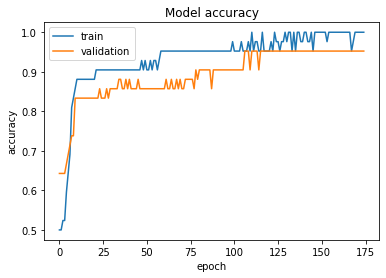

In [10]:
# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

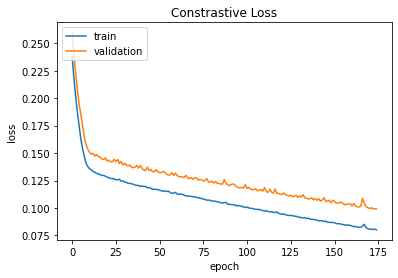

In [11]:
# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [12]:
""" Test the model """
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

1296/1296 [==============================] - 5s 4ms/sample - loss: 0.0959 - accuracy: 0.9506
test loss, test acc: [0.09593788690773057, 0.9506173]


In [13]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
Y_pred

array([0.28685403, 0.08015718, 0.6024718 , ..., 0.07277565, 0.13839976,
       0.0345658 ], dtype=float32)

In [14]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > .5
y_pred

array([False, False,  True, ..., False, False, False])

In [15]:
y_test = labels_test
y_test

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [16]:
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))


Evaluate on test data
Accuracy: 0.9506172839506173
Precision: 0.955056179775281
Recall: 0.9506172839506173
ROC AUC: 0.9506172839506173
F1: 0.9504965622612681


In [17]:
cm = confusion_matrix(y_test, y_pred)    
# cm_display = ConfusionMatrixDisplay(cm, labels_test).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

Specificity: 1.0


In [18]:
tf.keras.backend.clear_session()